## Synthetic Minority Oversampling TEchnique (SMOTE) to balance the training data-set
## This notebook is to apply SMOTE on Scania Dataset without PCA, with different Imbalance Ratio

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [55]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [56]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [57]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [58]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [59]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [60]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [61]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [62]:
def find_cut_off(y, y_predict_prob_maj):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob_maj)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob_maj > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

In [63]:
# data_dir ="ScaniaDataset/dimReduction/"
# df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
# df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

data_dir ="ScaniaDataset/imputation/"
df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [64]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [65]:
df_train.head()
df_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.027925,0.003496,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000163,0.007996,0.038972,0.015907,0.001463,0.0,0.034368,0.0,0.000000,0.0,0.000000,0.00000,0.035022,0.029911,0.022660,0.044285,0.0,0.0,0.0,0.0,0.001274,0.002297,0.0,0.0,0.0,0.0,0.000000,0.003754,0.033205,0.001436,0.007229,0.0,0.000531,0.000465,2.893584e-04,0.000271,5.000101e-03,0.011813,3.681733e-05,1.021497e-07,0.0,0.0,0.010000,0.008791,0.007444,0.007777,0.012332,0.035479,0.058892,0.000250,0.000000,0.000000,0.034739,0.000000,0.000033,0.000133,0.000979,0.034368,0.030469,0.021086,0.017480,0.252354,0.269627,0.228244,0.232853,0.216434,0.420683,0.444702,0.461499,0.172130,0.027925,0.034739,0.034739,0.035415,0.043479,0.001693,0.446972,0.527780,0.041502,0.0,0.050171,2.329835e-10,0.004486,0.000000,0.037208,0.0,0.016536,0.000046,0.026223,0.0,0.000000,0.000000e+00,0.001244,0.007709,0.027562,0.019164,0.002982,0.001486,4.417780e-05,2.562819e-08,0.000484,0.034739,0.000645,0.012483,0.002794,5.815179e-03,0.012301,0.005728,0.010592,0.012140,0.002044,0.000074,0.0,0.000584,0.001000,0.050517,0.001163,0.000000,2.780107e-02,0.000000,0.001868,0.044143,0.010630,0.006391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021296,0.045829,0.094192,0.000000e+00,0.000000,0.040779,0.057779,0.032041,0.014773,0.000000,0.000000,0.0,0.0,0.002118,0.023069,0.032751,0.012881,0.017378,0.015918,0.013067,7.421784e-03,8.179508e-03,1.073013e-02,0.001321,0.003800,0.000000,0.000000,0.000000,0
1,0.012036,0.003496,0.000000e+00,2.220573e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000080,0.003646,0.018302,0.008157,0.001787,0.0,0.018766,0.0,0.000012,0.0,0.000000,0.00000,0.018180,0.017407,0.013917,0.013244,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000572,0.006052,0.004078,0.000952,0.0,0.000725,0.001724,9.689357e-04,0.000287,8.208840e-03,0.004005,2.279950e-04,1.532245e-07,0.0,0.0,0.005920,0.003845,0.003575,0.004178,0.005457,0.007219,0.008733,0.016044,0.002785,0.000108,0.018907,0.000217,0.001481,0.000449,0.006856,0.018766,0.015318,0.015317,0.008575,0.260487,0.274495,0.279667,0.353789,0.391507,0.420683,0.444702,0.461499,0.006459,0.012036,0.018907,0.018907,0.019221,0.017698,0.006416,0.955934,0.005705,0.019802,0.0,0.000000,2.215927e-05,0.004277,0.000222,0.016250,0.0,0.011610,0.000000,0.000000,0.0,0.000000,6.494771e-07,0.001039,0.006944,0.010922,0.004667,0.001095,0.000688,1.538530e-06,2.219349e-05,0.000000,0.018907,0.000645,0.007340,0.001814,3.577230e-03,0.008252,0.003646,0.004847,0.004085,0.000710,0.000014,0.0,0.000823,0.001667,0.023635,0.007970,0.000294,1.011367e-03,0.000352,0.001392,0.018224,0.007440,0.002963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011535,0.019709,0.017052,0.000000e+00,0.000000,0.020787,0.024761,0.009800,0.006837,0.000000,0.000000,0.0,0.0,0.002630,0.020862,0.028186,0.008862,0.008391,0.005407,0.004716,3.019031e-03,4.272

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.000022,0.000000,9.386557e-09,1.397901e-09,0.0,0.0,0.0,0.0,0.0,0.000042,2.069654e-05,0.000022,0.000020,0.000000,0.000000,0.000000,0.000054,0.0,0.000000,0.0,0.000044,0.000042,0.000082,0.000078,0.001428,0.000018,0.0,0.0,0.000000,0.0,0.000073,0.000223,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000126,1.062436e-07,0.000193,0.000096,0.000005,0.000004,0.000002,0.000013,1.777389e-05,0.000075,0.000001,0.0,0.000038,0.000022,0.000009,0.000010,0.000008,0.000027,0.000005,0.000005,0.000002,0.000000,0.000645,0.000010,0.000020,0.000005,0.000000,0.000054,0.000099,0.002396,0.000076,0.213954,0.245177,0.304878,0.353789,0.391507,0.420683,0.444702,0.461499,0.106995,0.000022,0.000645,0.000645,0.000992,0.000054,0.000017,0.101243,0.102421,0.000089,0.0,0.000122,0.000000e+00,0.000280,0.0,0.000042,0.000000,0.000106,0.000046,0.000409,0.0,1.378075e-07,9.420836e-05,0.000049,0.000008,0.000013,5.271890e-07,1.206865e-07,0.000000,0.000000,9.319341e-10,0.000024,0.000645,0.000000,0.001847,0.000032,7.811493e-07,6.128916e-07,0.000012,0.000001,0.000104,0.000178,0.000130,0.0,0.000024,0.000057,0.000065,0.000029,0.000000,0.000000e+00,0.0,0.000000,0.000055,0.000157,0.000636,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000116,0.000000,0.000000,1.731773e-07,0.000011,0.000047,0.000101,0.000002,0.000007,0.000000,0.000001,0.0,0.0,0.000000,0.004391,0.001087,0.000100,0.000032,0.000014,0.000004,0.000004,0.000011,0.000002,7.359084e-07,0.000000,0.000000,0.0,0.0,0
1,0.000030,0.000000,3.191429e-08,4.659671e-09,0.0,0.0,0.0,0.0,0.0,0.000000,3.268794e-06,0.000070,0.000039,0.000000,0.000000,0.000000,0.000071,0.0,0.000011,0.0,0.000000,0.000000,0.000165,0.000149,0.000304,0.000050,0.0,0.0,0.000000,0.0,0.000015,0.000703,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000001,0.000156,0.000000e+00,0.000028,0.000010,0.000004,0.000028,0.000007,0.000007,1.718865e-04,0.000000,0.000000,0.0,0.000054,0.000015,0.000011,0.000007,0.000007,0.000007,0.000043,0.000022,0.000006,0.000003,0.000243,0.000010,0.000007,0.000047,0.000000,0.000071,0.000112,0.000457,0.000069,0.213954,0.245177,0.304878,0.353789,0.391507,0.420683,0.444702,0.461499,0.022483,0.000030,0.000243,0.000243,0.000258,0.000068,0.000000,0.037088,0.038428,0.000115,0.0,0.000148,2.329835e-10,0.000187,0.0,0.000051,0.000000,0.000140,0.000000,0.000572,0.0,0.000000e+00,6.836601e-08,0.000074,0.000036,0.000021,1.728625e-05,3.620594e-07,0.000000,0.000000,1.630885e-09,0.000109,0.000243,0.000000,0.002624,0.000064,2.473639e-06,8.250464e-06,0.000009,0.000005,0.000130,0.000169,0.000050,0.0,0.000088,0.000281,0.000096,0.000033,0.000000,0.000000e+00,0.0,0.000000,0.000066,0.000175,0.000227,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000120,0.000000,0.000000,6.291058e-07,0.000012,0.000040,0.000094,0.000082,0.000030,0.000056,0.000009,0.0,0.0,0.000000,0.000027,0.001232,0.000134,0.00003

----

### Generate data by SMOTE to preserve different ratio between the majoirty and minority classes

In [66]:
from collections import Counter
from numpy import log
from imblearn.over_sampling import SMOTE 

**Using the Shannon entropy as a measure of balance**
- Where IR tends to be:
    - 0 when the data is highly imbalanced and 
    - 1 when the data is balanced.

- Inspired from: 
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance


In [67]:
def imbalance_ratio(seq):
    n = len(seq)
    classes = [(label,float(count)) for 
               label,count in Counter(seq).items()]
    #print(classes)
    k = len(classes)
    #print(k)
    #calculate shannon entropy
    H = -sum([ (count/n) * log((count/n)) 
              for label,count in classes]) 
    #print(H)
    # get imbalance ratio
    IR = H/log(k)
    print("Non-normliased = ", str(H))
    print("IR = ", str(IR))
    return IR # near 0: high imbalance, near 1: high balance

**Check if we have the same value report for Normalised Shannon Entropy that is calculated in paper "A methodology..." isn't normalised**
- It turns out the shannon value in their paper isn't normalised, check the example on the original data
- Original data has the following counts for each class
[(0, 59000.0), (1, 1000.0)]

In [68]:
log((1/60)) 

-4.0943445622221

In [69]:
#[(0, 59000.0), (1, 1000.0)]
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))/log(2)

0.08476607571480994

0.1222915970693747

**Measure IR for the original data**

In [70]:
imbalance_ratio(df_train["class"])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747


0.1222915970693747

**Get the minority class samples**

In [71]:
def get_minority(df_train):
    return df_train[df_train['class'] == 1]

**Define smote function**

In [72]:
def generate_smote(df, k = 5, sampling_strategy = 5/59):
    sm = SMOTE(random_state=RANDOM_STATE, 
               k_neighbors=k, n_jobs=-1, 
               sampling_strategy=sampling_strategy)
    df = df.apply(pd.to_numeric)
    y_train = df['class']
    X_train = df.drop(['class'], axis=1)
    
    y_train_0 = sum(y_train==0)
    y_train_1 = sum(y_train==1)
    print("Before OverSampling, counts of label '1': {} ({}%)".format(y_train_1, y_train_1/len(y_train) * 100))
    print("Before OverSampling, counts of label '0': {} ({}%)\n".format(y_train_0, y_train_0/len(y_train) * 100))
    
    # Apply smote
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    
    y_train_res_0 = sum(y_train_res == 0)
    y_train_res_1 = sum(y_train_res == 1)
    
    print("After OverSampling, counts of label '1': {} ({}%)".format(y_train_res_1, y_train_res_1/len(y_train_res)* 100))
    print("After OverSampling, counts of label '0': {} ({}%)".format(y_train_res_0, y_train_res_0/len(y_train_res)* 100))
    
    df_ = pd.DataFrame(X_train_res, columns=X_train.columns)
    df_["class"] = y_train_res
    return df_

**To reproduce Case II Experiements:**
- sampling_strategy = 2/59 => IR = 0.2
- sampling_strategy = 5/59 => IR = 0.4
- sampling_strategy = 9/59, 10/59, 11/59 => IR = 0.6
- sampling_strategy = 18/59 => IR = 0.8
- sampling_strategy = 59/59 => IR = 1.0

**define a dataframe for each case**

In [73]:
#sample_strategies = [2, 5, 10, 18, 59]

In [74]:
x=imbalance_ratio(df_train['class'])

print("".join(["="]*20))
## create df for IR = 0.2
df_train_2 = generate_smote(df_train, sampling_strategy = 2/59)
x=imbalance_ratio(df_train_2['class'])
print("".join(["="]*20))

## create df for IR = 0.4
df_train_5 = generate_smote(df_train, sampling_strategy = 5/59)
x=imbalance_ratio(df_train_5['class'])
print("".join(["="]*20))

## create df for IR = 0.6
df_train_10 = generate_smote(df_train, sampling_strategy = 10/59)
x=imbalance_ratio(df_train_10['class'])
print("".join(["="]*20))

## create df for IR = 0.8
df_train_18 = generate_smote(df_train, sampling_strategy = 18/59)
x=imbalance_ratio(df_train_18['class'])
print("".join(["="]*20))

## create df for IR = 1.0
df_train_59 = generate_smote(df_train, sampling_strategy = 1.0)
x=imbalance_ratio(df_train_59['class'])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 2000 (3.278688524590164%)
After OverSampling, counts of label '0': 59000 (96.72131147540983%)
Non-normliased =  0.14430003545925657
IR =  0.20818094555717104
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 5000 (7.8125%)
After OverSampling, counts of label '0': 59000 (92.1875%)
Non-normliased =  0.27416591535017265
IR =  0.3955378064564774
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 10000 (14.492753623188406%)
After OverSampling, counts of label '0': 59000 (85.5072463768116%)
Non-norm

## Get difference between generated and original
**Note: SMOTE concatenates the newly generated samples to the end of the original input data and returns that as the output**
- ref: https://datascience.stackexchange.com/questions/12768/location-of-the-resampled-data-from-smote

In [75]:
# get minority of the original data
df_minority = get_minority(df_train)
len(df_minority)

1000

In [76]:
# df_minroty: is the data samples of the minority class in the original data
# df_generated: is all data samples including synthetic generated minority class and original data samples
from scipy import stats
def get_ks_test(df_minroty, df_generated, return_generated_df = False):
    # get the generated samples from smote by getting the difference between original dataset in "df_train" and sampled dataset "df_generated"
    # (which contains/combines original and generated data)
    minority_generated = df_generated[~df_generated.apply(tuple,1).isin(df_train.apply(tuple,1))]
    no_cols = len(df_minroty.columns)-1
    for idx in range(0, no_cols):
        print(stats.ks_2samp(df_minroty.iloc[:,idx], 
                       minority_generated.iloc[:, idx]))
    if return_generated_df:
        return minority_generated
    

In [77]:
minority_generated = df_train_5[~df_train_5.apply(tuple,1).isin(df_train.apply(tuple,1))]
minority_generated = minority_generated.drop(['class'], axis=1)
# minority_generated

minority_original = df_minority.drop(['class'], axis=1)
# minority_original

In [78]:
# minority_original.corrwith(minority_generated, axis=0)

In [79]:
# from scipy.stats import pearsonr
# corr, _ = pearsonr(minority_original, minority_generated)
# corr
# p = minority_generated.to_numpy()
# q = minority_original.to_numpy()

# BC=np.sum(np.sqrt(p*q))
# BC

In [80]:
# get_ks_test(df_minority, df_train_2)

In [81]:
#get_ks_test(df_minority, df_train_5)

In [82]:
#get_ks_test(df_minority, df_train_10)

In [83]:
#get_ks_test(df_minority, df_train_18)

In [84]:
#get_ks_test(df_minority, df_train_59)

In [85]:
# df_2_generated = df_train_2[~df_train_2.apply(tuple,1).isin(df_train.apply(tuple,1))]
# len(df_2_generated)

**Prepare test dataset**

In [86]:
y_test = df_test['class']
X_test = df_test.drop(['class'], axis=1)

In [87]:
len(X_test)

16000

----

## ML Predictive models on the data with augmentation minotity samples generated from SMOTE
**LR, RF, XGBoost are trained and tested for each case mentioned above**

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [89]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

**Prepare training dataset**

In [90]:
def get_train_data(df_t):
    y_train = df_t['class']
    X_train = df_t.drop(['class'], axis=1)
    return X_train, y_train
    

**Make prediction of best model given X_test**

In [91]:
def model_prediction(best_model, X_test):
    print("Best estimator: ", best_model.best_estimator_)
    # X = X.values.reshape(-1, 1)
    model_prediction = best_model.predict(X_test)
    model_prob_prediction = best_model.predict_proba(X_test) 
    return model_prediction, model_prob_prediction

### Logistic Regression: 

In [92]:
# y_train = df_train['class']
# X_train = df_train.drop(['class'], axis=1)

In [93]:
def lr_model(X_train, y_train):
    # LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
    #                          max_iter=[6000])  # hyperparameter options

    # # Best options obtained from running the params mentioned above
    LR_hyperparameters = dict(C=[10], max_iter=[6000])  # hyperparameter options
    LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

    LR_best_model = LR_clf.fit(X_train, y_train)
    return LR_best_model

### df_train_2 (i.e. IR = 0.2)

In [94]:
X_train_2, y_train_2 = get_train_data(df_train_2)
LR_best_model_2 = lr_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.9s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.48      0.91      0.63       375

    accuracy                           0.97     16000
   macro avg       0.74      0.95      0.81     16000
weighted avg       0.99      0.97      0.98     16000

[[15256   369]
 [   32   343]]
Accuracy: 0.9749375
roc_auc_score: 0.9455253333333334
precision_score: 0.48174157303370785
recall_score: 0.9146666666666666
f1_score: 0.6310947562097515
CM: FP 369
CM: FN 32
APS Cost =  19690


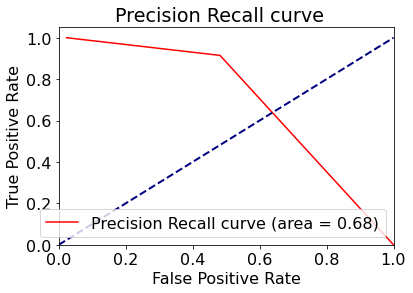

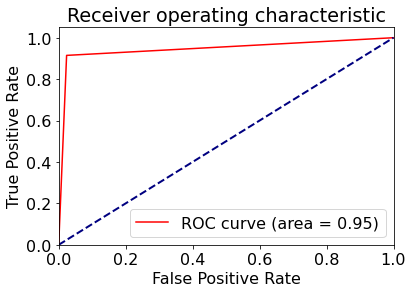

In [95]:
LR_model_pred_test_2, LR_model_prob_pred_test_2 = model_prediction(LR_best_model_2, X_test)
model_evaluaiton(y_test, LR_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59000
           1       0.56      0.95      0.71      2000

    accuracy                           0.97     61000
   macro avg       0.78      0.96      0.85     61000
weighted avg       0.98      0.97      0.98     61000

[[57528  1472]
 [   97  1903]]
Accuracy: 0.9742786885245902
roc_auc_score: 0.9632754237288136
precision_score: 0.5638518518518518
recall_score: 0.9515
f1_score: 0.7080930232558139
CM: FP 1472
CM: FN 97
APS Cost =  63220


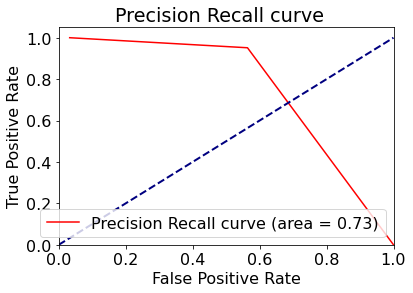

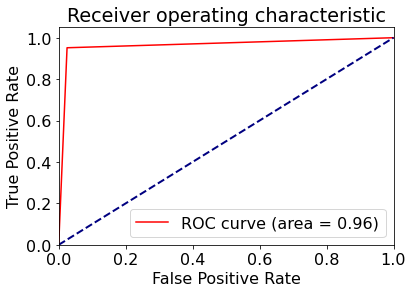

In [96]:
LR_model_pred_train_2, LR_model_prob_pred_train_2 = model_prediction(LR_best_model_2, X_train_2)
model_evaluaiton(y_train_2, LR_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [97]:
LR_best_th_2 = find_cut_off(y_test, LR_model_prob_pred_test_2[:,1])

100%|██████████| 15979/15979 [11:29<00:00, 23.17it/s]


Best threshold: 0.2944
Min cost: 15330.00


In [98]:
LR_best_th_2

0.29443565691714413

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.95      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14992   633]
 [   18   357]]
Accuracy: 0.9593125
roc_auc_score: 0.955744
precision_score: 0.3606060606060606
recall_score: 0.952
f1_score: 0.523076923076923
CM: FP 633
CM: FN 18
APS Cost =  15330


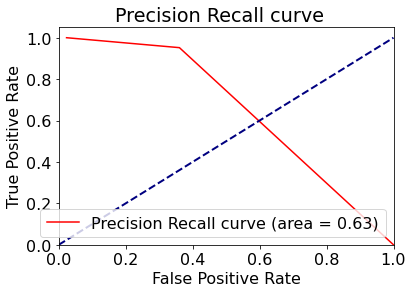

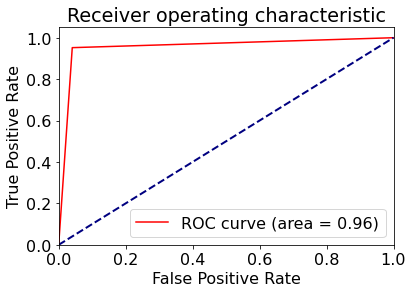

In [99]:
LR_predict_test_th_2 = LR_model_prob_pred_test_2[:,1] > LR_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [100]:
(1.0-LR_best_th_2)
lr_th_2 = round((1.0-LR_best_th_2),3)
lr_th_2

0.7055643430828559

0.706

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.95      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14990   635]
 [   18   357]]
Accuracy: 0.9591875
roc_auc_score: 0.95568
precision_score: 0.3598790322580645
recall_score: 0.952
f1_score: 0.5223116313094367
CM: FP 635
CM: FN 18
APS Cost =  15350


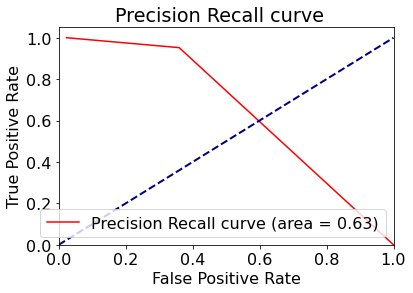

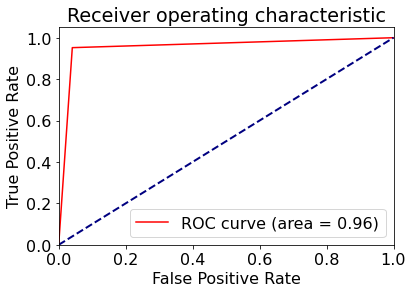

In [101]:
y_2 = LR_model_prob_pred_test_2[:,0] < lr_th_2
model_evaluaiton(y_test, y_2, "")

----

### Logistic Regression : df_train_5 (i.e. IR = 0.4)

In [102]:
X_train_5, y_train_5 = get_train_data(df_train_5)
LR_best_model_5 = lr_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.9s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.49      0.93      0.64       375

    accuracy                           0.98     16000
   macro avg       0.74      0.95      0.81     16000
weighted avg       0.99      0.98      0.98     16000

[[15266   359]
 [   28   347]]
Accuracy: 0.9758125
roc_auc_score: 0.9511786666666667
precision_score: 0.4915014164305949
recall_score: 0.9253333333333333
f1_score: 0.6419981498612396
CM: FP 359
CM: FN 28
APS Cost =  17590


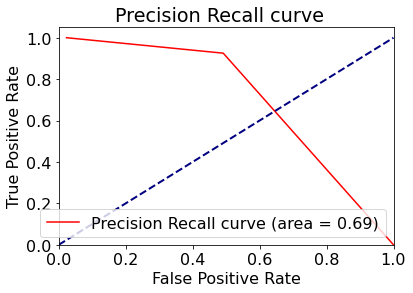

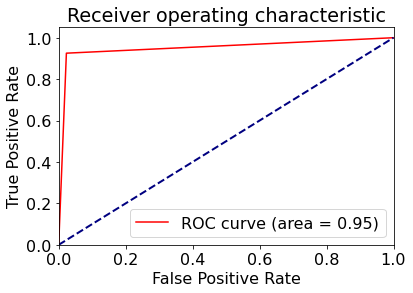

In [103]:
LR_model_pred_test_5, LR_model_prob_pred_test_5 = model_prediction(LR_best_model_5, X_test)
model_evaluaiton(y_test, LR_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59000
           1       0.77      0.95      0.85      5000

    accuracy                           0.97     64000
   macro avg       0.88      0.96      0.92     64000
weighted avg       0.98      0.97      0.98     64000

[[57587  1413]
 [  242  4758]]
Accuracy: 0.974140625
roc_auc_score: 0.9638254237288135
precision_score: 0.771025765678172
recall_score: 0.9516
f1_score: 0.8518485363888639
CM: FP 1413
CM: FN 242
APS Cost =  135130


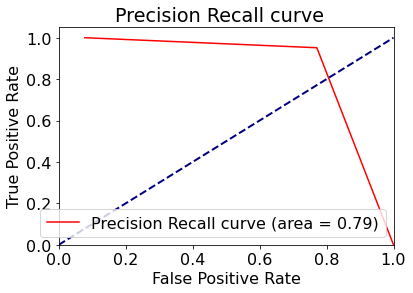

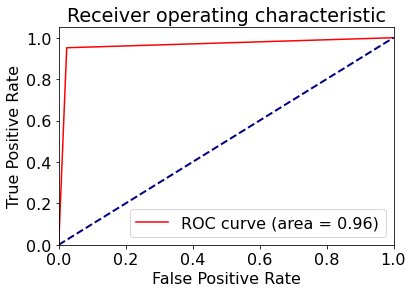

In [104]:
LR_model_pred_train_5, LR_model_prob_pred_train_5 = model_prediction(LR_best_model_5, X_train_5)
model_evaluaiton(y_train_5, LR_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [105]:
LR_best_th_5 = find_cut_off(y_test, LR_model_prob_pred_test_5[:,1])

100%|██████████| 15975/15975 [11:20<00:00, 23.46it/s]

Best threshold: 0.2789
Min cost: 13850.00


In [106]:
LR_best_th_5

0.2789196721690258

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.96      0.53       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14990   635]
 [   15   360]]
Accuracy: 0.959375
roc_auc_score: 0.9596799999999999
precision_score: 0.36180904522613067
recall_score: 0.96
f1_score: 0.5255474452554745
CM: FP 635
CM: FN 15
APS Cost =  13850


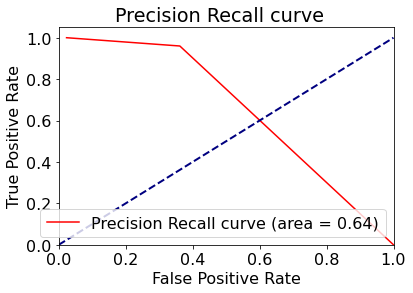

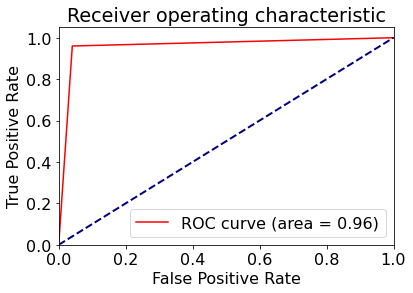

In [107]:
LR_predict_test_th_5 = LR_model_prob_pred_test_5[:,1] > LR_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [108]:
(1.0-LR_best_th_5)
lr_th_5 = round((1.0-LR_best_th_5),3)
lr_th_5

0.7210803278309742

0.721

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.96      0.53       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14990   635]
 [   15   360]]
Accuracy: 0.959375
roc_auc_score: 0.9596799999999999
precision_score: 0.36180904522613067
recall_score: 0.96
f1_score: 0.5255474452554745
CM: FP 635
CM: FN 15
APS Cost =  13850


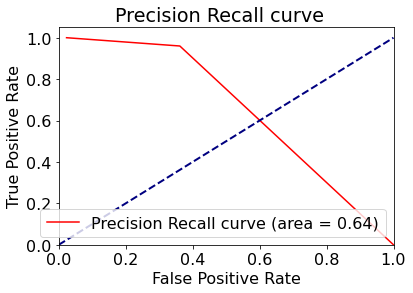

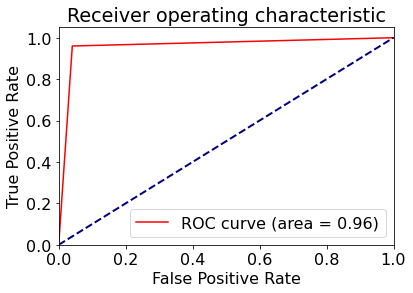

In [109]:
y_5 = LR_model_prob_pred_test_5[:,0] < lr_th_5
model_evaluaiton(y_test, y_5, "")

-----

### Logistic Regression : df_train_10 (i.e. IR = 0.6)

In [110]:
X_train_10, y_train_10 = get_train_data(df_train_10)
LR_best_model_10 = lr_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.5s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.50      0.92      0.65       375

    accuracy                           0.98     16000
   macro avg       0.75      0.95      0.82     16000
weighted avg       0.99      0.98      0.98     16000

[[15280   345]
 [   29   346]]
Accuracy: 0.976625
roc_auc_score: 0.9502933333333334
precision_score: 0.5007235890014472
recall_score: 0.9226666666666666
f1_score: 0.6491557223264541
CM: FP 345
CM: FN 29
APS Cost =  17950


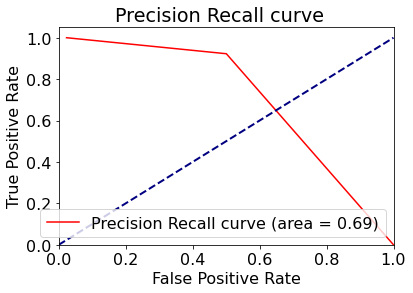

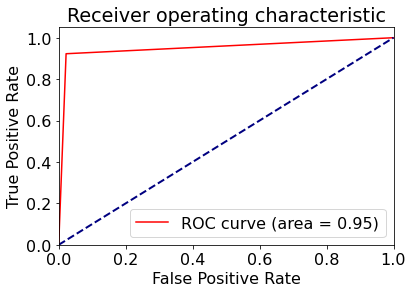

In [111]:
LR_model_pred_test_10, LR_model_prob_pred_test_10 = model_prediction(LR_best_model_10, X_test)
model_evaluaiton(y_test, LR_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     59000
           1       0.87      0.95      0.91     10000

    accuracy                           0.97     69000
   macro avg       0.93      0.96      0.95     69000
weighted avg       0.97      0.97      0.97     69000

[[57616  1384]
 [  496  9504]]
Accuracy: 0.9727536231884057
roc_auc_score: 0.9634711864406781
precision_score: 0.8728875826598089
recall_score: 0.9504
f1_score: 0.9099961700497894
CM: FP 1384
CM: FN 496
APS Cost =  261840


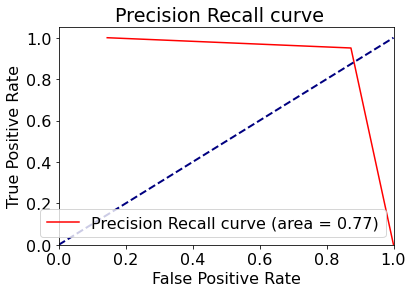

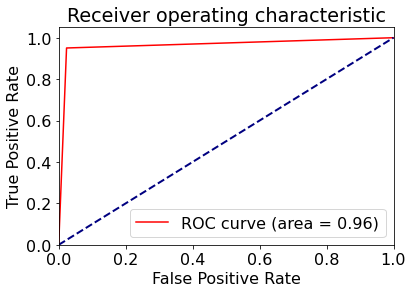

In [112]:
LR_model_pred_train_10, LR_model_prob_pred_train_10 = model_prediction(LR_best_model_10, X_train_10)
model_evaluaiton(y_train_10, LR_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [113]:
LR_best_th_10 = find_cut_off(y_test, LR_model_prob_pred_test_10[:,1])

100%|██████████| 15973/15973 [12:11<00:00, 21.83it/s]

Best threshold: 0.2135
Min cost: 15280.00


In [114]:
LR_best_th_10

0.21348315169325285

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.30      0.96      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14797   828]
 [   14   361]]
Accuracy: 0.947375
roc_auc_score: 0.9548373333333334
precision_score: 0.3036164844407065
recall_score: 0.9626666666666667
f1_score: 0.46163682864450134
CM: FP 828
CM: FN 14
APS Cost =  15280


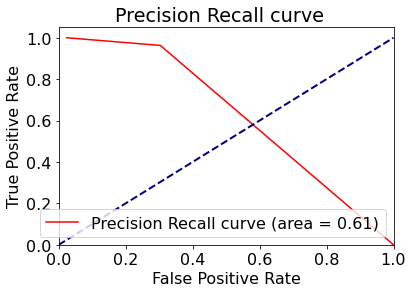

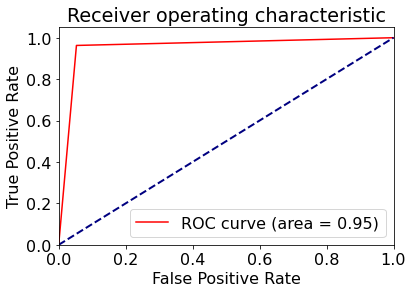

In [115]:
LR_predict_test_th_10 = LR_model_prob_pred_test_10[:,1] > LR_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [116]:
(1.0-LR_best_th_10)
lr_th_3 = round((1.0-LR_best_th_10),3)
lr_th_3

0.7865168483067472

0.787

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.30      0.96      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14791   834]
 [   14   361]]
Accuracy: 0.947
roc_auc_score: 0.9546453333333335
precision_score: 0.30209205020920504
recall_score: 0.9626666666666667
f1_score: 0.4598726114649682
CM: FP 834
CM: FN 14
APS Cost =  15340


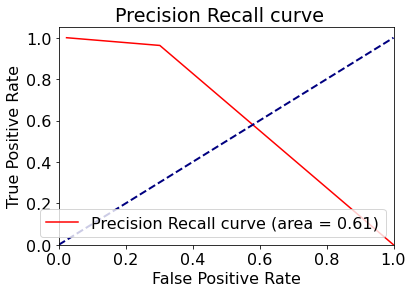

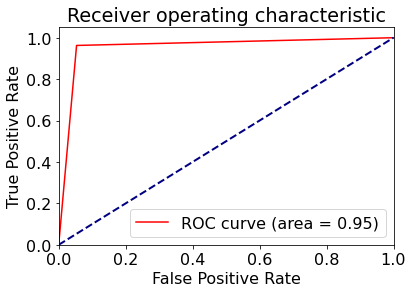

In [117]:
y_10 = LR_model_prob_pred_test_10[:,0] < lr_th_3
model_evaluaiton(y_test, y_10, "")

----

### Logistic Regression : df_train_18 (i.e. IR = 0.8)

In [118]:
X_train_18, y_train_18 = get_train_data(df_train_18)
LR_best_model_18 = lr_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.1s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.50      0.92      0.64       375

    accuracy                           0.98     16000
   macro avg       0.75      0.95      0.82     16000
weighted avg       0.99      0.98      0.98     16000

[[15275   350]
 [   30   345]]
Accuracy: 0.97625
roc_auc_score: 0.9488
precision_score: 0.49640287769784175
recall_score: 0.92
f1_score: 0.6448598130841122
CM: FP 350
CM: FN 30
APS Cost =  18500


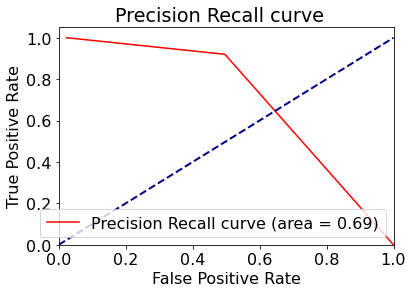

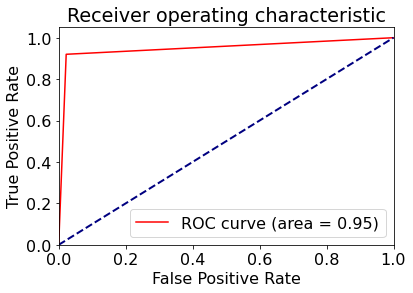

In [119]:
LR_model_pred_test_18, LR_model_prob_pred_test_18 = model_prediction(LR_best_model_18, X_test)
model_evaluaiton(y_test, LR_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     59000
           1       0.93      0.95      0.94     18000

    accuracy                           0.97     77000
   macro avg       0.96      0.96      0.96     77000
weighted avg       0.97      0.97      0.97     77000

[[57612  1388]
 [  872 17128]]
Accuracy: 0.9706493506493507
roc_auc_score: 0.964015065913371
precision_score: 0.9250378051414992
recall_score: 0.9515555555555556
f1_score: 0.9381093219410669
CM: FP 1388
CM: FN 872
APS Cost =  449880


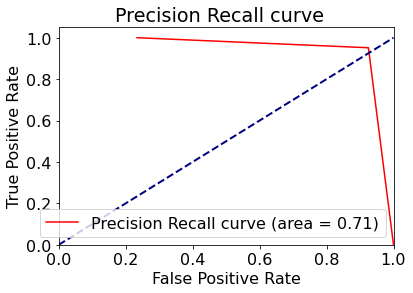

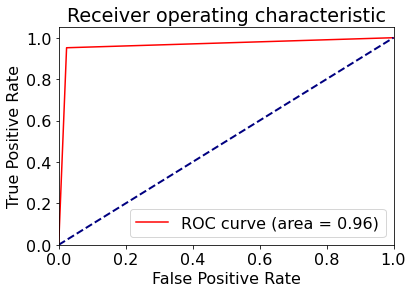

In [120]:
LR_model_pred_train_18, LR_model_prob_pred_train_18 = model_prediction(LR_best_model_18, X_train_18)
model_evaluaiton(y_train_18, LR_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_18[:, 1] : classifier probability's output for minority class

In [121]:
LR_best_th_18 = find_cut_off(y_test, LR_model_prob_pred_test_18[:,1])

100%|██████████| 15973/15973 [11:30<00:00, 23.14it/s]

Best threshold: 0.2479
Min cost: 14580.00


In [122]:
LR_best_th_18

0.24791297527484105

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15625
           1       0.34      0.96      0.50       375

    accuracy                           0.95     16000
   macro avg       0.67      0.96      0.74     16000
weighted avg       0.98      0.95      0.97     16000

[[14917   708]
 [   15   360]]
Accuracy: 0.9548125
roc_auc_score: 0.9573439999999999
precision_score: 0.33707865168539325
recall_score: 0.96
f1_score: 0.498960498960499
CM: FP 708
CM: FN 15
APS Cost =  14580


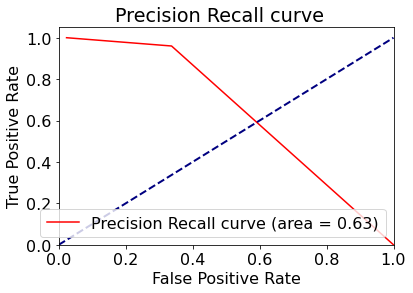

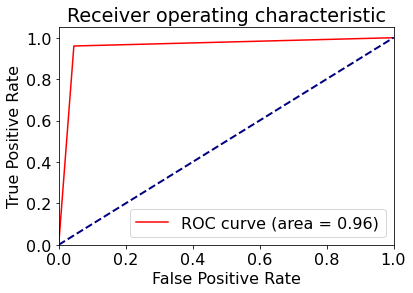

In [123]:
LR_predict_test_th_18 = LR_model_prob_pred_test_18[:,1] > LR_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [124]:
(1.0-LR_best_th_18)
lr_th_18 = round((1.0-LR_best_th_18),3)
lr_th_18

0.752087024725159

0.752

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15625
           1       0.34      0.96      0.50       375

    accuracy                           0.95     16000
   macro avg       0.67      0.96      0.74     16000
weighted avg       0.98      0.95      0.97     16000

[[14917   708]
 [   15   360]]
Accuracy: 0.9548125
roc_auc_score: 0.9573439999999999
precision_score: 0.33707865168539325
recall_score: 0.96
f1_score: 0.498960498960499
CM: FP 708
CM: FN 15
APS Cost =  14580


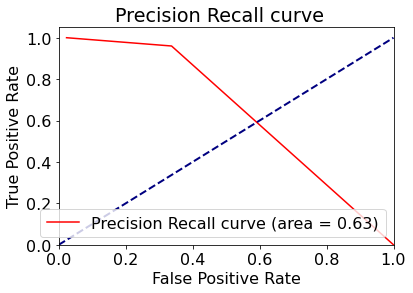

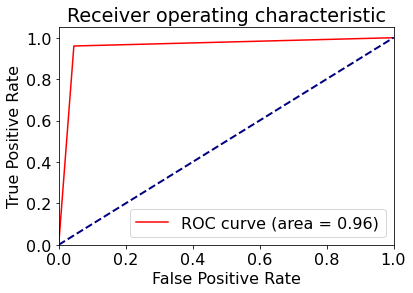

In [125]:
y_18 = LR_model_prob_pred_test_18[:,0] < lr_th_18
model_evaluaiton(y_test, y_18, "")

------

### Logistic Regression : df_train_59 (i.e. IR = 1.0)

In [126]:
X_train_59, y_train_59 = get_train_data(df_train_59)
LR_best_model_59 = lr_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   45.6s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.0s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.50      0.92      0.65       375

    accuracy                           0.98     16000
   macro avg       0.75      0.95      0.82     16000
weighted avg       0.99      0.98      0.98     16000

[[15277   348]
 [   30   345]]
Accuracy: 0.976375
roc_auc_score: 0.948864
precision_score: 0.49783549783549785
recall_score: 0.92
f1_score: 0.6460674157303371
CM: FP 348
CM: FN 30
APS Cost =  18480


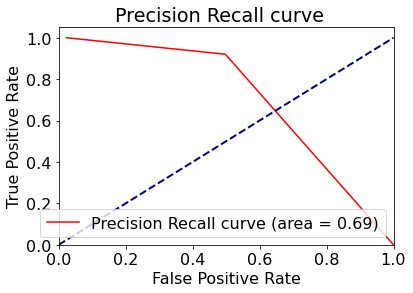

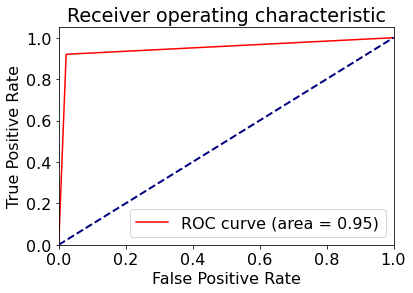

In [127]:
LR_model_pred_test_59, LR_model_prob_pred_test_59 = model_prediction(LR_best_model_59, X_test)
model_evaluaiton(y_test, LR_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     59000
           1       0.98      0.95      0.96     59000

    accuracy                           0.97    118000
   macro avg       0.97      0.97      0.97    118000
weighted avg       0.97      0.97      0.97    118000

[[57657  1343]
 [ 2756 56244]]
Accuracy: 0.9652627118644068
roc_auc_score: 0.9652627118644067
precision_score: 0.9766787643044437
recall_score: 0.9532881355932203
f1_score: 0.9648417061936579
CM: FP 1343
CM: FN 2756
APS Cost =  1391430


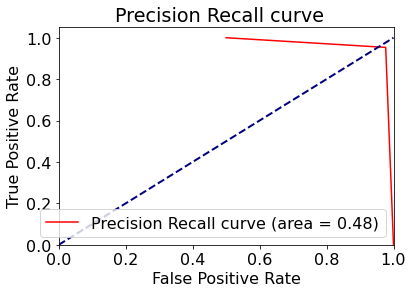

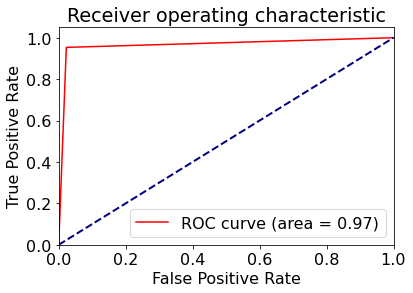

In [128]:
LR_model_pred_train_59, LR_model_prob_pred_train_59 = model_prediction(LR_best_model_59, X_train_59)
model_evaluaiton(y_train_59, LR_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [129]:
LR_best_th_59 = find_cut_off(y_test, LR_model_prob_pred_test_59[:,1])

100%|██████████| 15967/15967 [11:03<00:00, 24.08it/s]

Best threshold: 0.2271
Min cost: 14970.00


In [130]:
LR_best_th_59

0.2270626629367907

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15625
           1       0.33      0.96      0.49       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14878   747]
 [   15   360]]
Accuracy: 0.952375
roc_auc_score: 0.9560960000000001
precision_score: 0.3252032520325203
recall_score: 0.96
f1_score: 0.4858299595141701
CM: FP 747
CM: FN 15
APS Cost =  14970


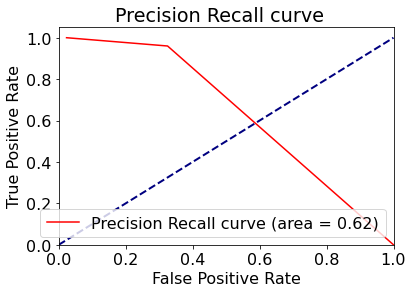

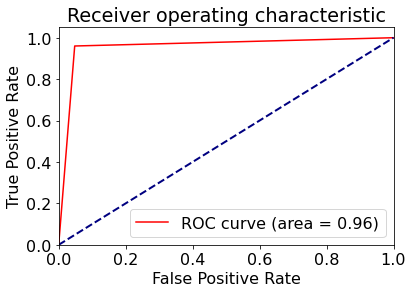

In [131]:
LR_predict_test_th_59 = LR_model_prob_pred_test_59[:,1] > LR_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [132]:
(1.0-LR_best_th_59)
lr_th_59 = round((1.0-LR_best_th_59),3)
lr_th_59

0.7729373370632093

0.773

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.96      0.49       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14877   748]
 [   15   360]]
Accuracy: 0.9523125
roc_auc_score: 0.9560639999999999
precision_score: 0.3249097472924188
recall_score: 0.96
f1_score: 0.4855023600809171
CM: FP 748
CM: FN 15
APS Cost =  14980


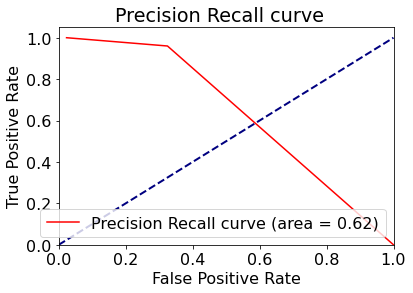

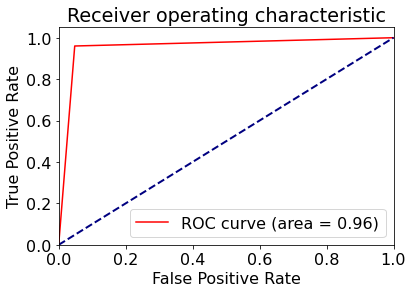

In [133]:
y_59 = LR_model_prob_pred_test_59[:,0] < lr_th_59
model_evaluaiton(y_test, y_59, "")

----

----

----

### Random Forest

In [134]:
def RF_model(X_train, y_train):
    # RF_hyperparameters = {
    #             'n_estimators': [50, 100, 250],
    #              'max_features': ['auto', 'sqrt', 'log2'],
    #             # 'max_depth': [5, 6, 8, None],
    #             'max_depth': [5, 6, 8],
    #             'criterion': ['gini', 'entropy']}

    ## Best Params based on running the previous range of hyperparameter
    RF_hyperparameters = {
                          'n_estimators': [250],
                           'max_depth': [5],
                          'criterion': ['gini']}
    RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                                   param_grid=RF_hyperparameters, cv=5,
                                   verbose=2, scoring=scoring_fn, n_jobs=-1)

    RF_best_model = RF_clf.fit(X_train, y_train)
    return RF_best_model

### df_train_2 (i.e. IR = 0.2)

In [135]:
X_train_2, y_train_2 = get_train_data(df_train_2)
RF_best_model_2 = RF_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.4s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.5s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.37      0.96      0.53       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.76     16000
weighted avg       0.98      0.96      0.97     16000

[[15005   620]
 [   14   361]]
Accuracy: 0.960375
roc_auc_score: 0.9614933333333334
precision_score: 0.36799

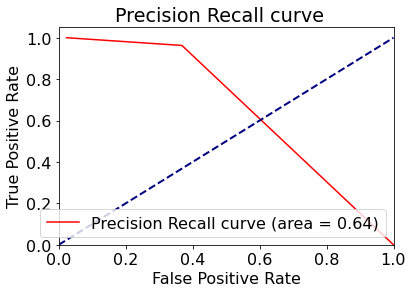

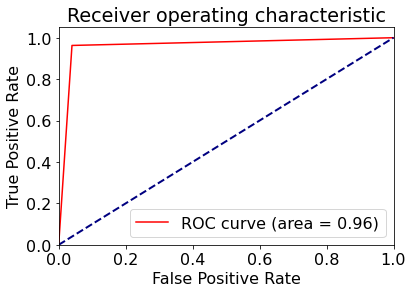

In [136]:
RF_model_pred_test_2, RF_model_prob_pred_test_2 = model_prediction(RF_best_model_2, X_test)
model_evaluaiton(y_test, RF_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59000
           1       0.44      0.97      0.61      2000

    accuracy                           0.96     61000
   macro avg       0.72      0.96      0.79     61000
weighted avg       0.98      0.96      0.97     61000

[[56558  2442]
 [   59  1941]]
Accuracy: 0.959
roc_auc_score: 0.9645550847457627
precision_score: 0.44284736

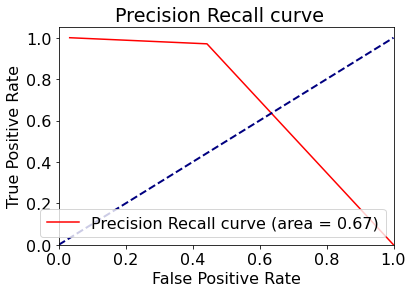

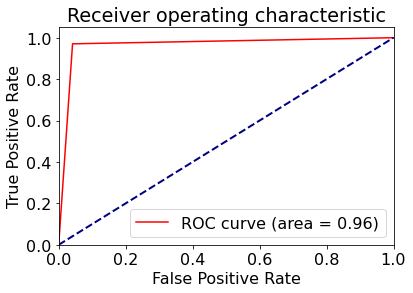

In [137]:
RF_model_pred_train_2, RF_model_prob_pred_train_2 = model_prediction(RF_best_model_2, X_train_2)
model_evaluaiton(y_train_2, RF_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [138]:
RF_best_th_2 = find_cut_off(y_test, RF_model_prob_pred_test_2[:,1])

100%|██████████| 2509/2509 [01:40<00:00, 25.08it/s]

Best threshold: 0.4567
Min cost: 10740.00


In [139]:
RF_best_th_2

0.4567452261776754

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.35      0.98      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14951   674]
 [    8   367]]
Accuracy: 0.957375
roc_auc_score: 0.9677653333333334
precision_score: 0.3525456292026897
recall_score: 0.9786666666666667
f1_score: 0.518361581920904
CM: FP 674
CM: FN 8
APS Cost =  10740


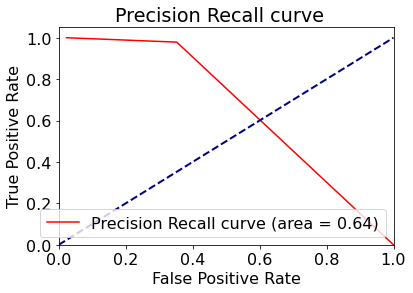

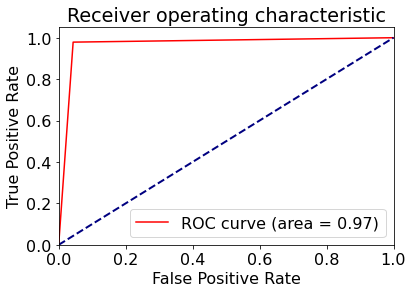

In [140]:
RF_predict_test_th_2 = RF_model_prob_pred_test_2[:,1] > RF_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [141]:
(1.0-RF_best_th_2)
rf_th_2 = round((1.0-RF_best_th_2),3)
rf_th_2

0.5432547738223246

0.543

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.35      0.98      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14951   674]
 [    8   367]]
Accuracy: 0.957375
roc_auc_score: 0.9677653333333334
precision_score: 0.3525456292026897
recall_score: 0.9786666666666667
f1_score: 0.518361581920904
CM: FP 674
CM: FN 8
APS Cost =  10740


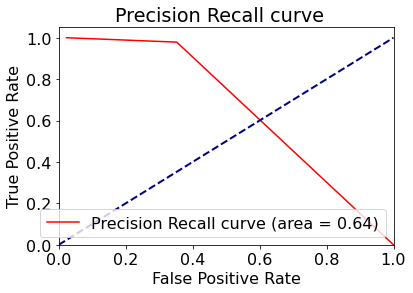

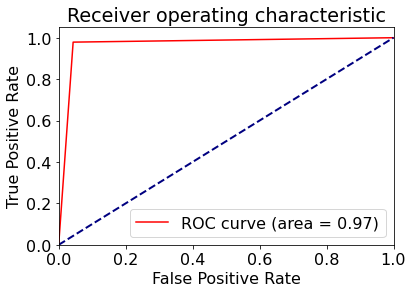

In [142]:
y_2 = RF_model_prob_pred_test_2[:,0] < rf_th_2
model_evaluaiton(y_test, y_2, "")

------

### df_train_5 (i.e. IR = 0.4)

In [143]:
X_train_5, y_train_5 = get_train_data(df_train_5)
RF_best_model_5 = RF_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   41.3s remaining:   27.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.96      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14980   645]
 [   14   361]]
Accuracy: 0.9588125
roc_auc_score: 0.9606933333333334
precision_score: 0.3588

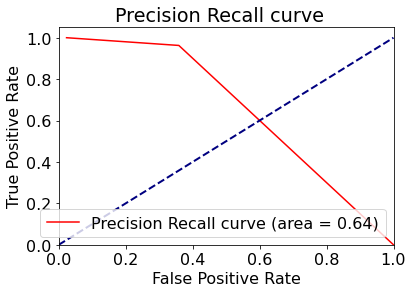

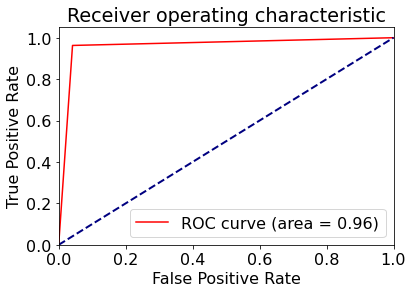

In [144]:
RF_model_pred_test_5, RF_model_prob_pred_test_5 = model_prediction(RF_best_model_5, X_test)
model_evaluaiton(y_test, RF_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59000
           1       0.66      0.98      0.79      5000

    accuracy                           0.96     64000
   macro avg       0.83      0.97      0.88     64000
weighted avg       0.97      0.96      0.96     64000

[[56465  2535]
 [  114  4886]]
Accuracy: 0.958609375
roc_auc_score: 0.9671169491525423
precision_score: 0.65

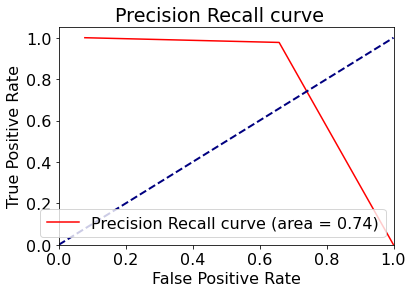

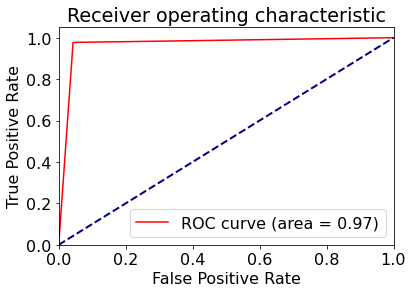

In [145]:
RF_model_pred_train_5, RF_model_prob_pred_train_5 = model_prediction(RF_best_model_5, X_train_5)
model_evaluaiton(y_train_5, RF_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [146]:
RF_best_th_5 = find_cut_off(y_test, RF_model_prob_pred_test_5[:,1])

100%|██████████| 2356/2356 [01:33<00:00, 25.16it/s]

Best threshold: 0.3625
Min cost: 11680.00


In [147]:
RF_best_th_5

0.36252015878614785

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.98      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14807   818]
 [    7   368]]
Accuracy: 0.9484375
roc_auc_score: 0.9644906666666667
precision_score: 0.3102866779089376
recall_score: 0.9813333333333333
f1_score: 0.4714926329276105
CM: FP 818
CM: FN 7
APS Cost =  11680


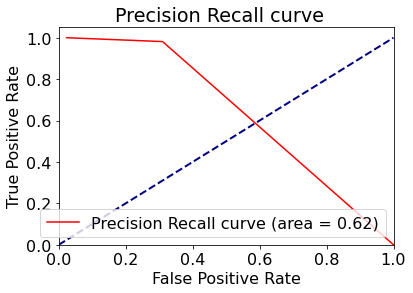

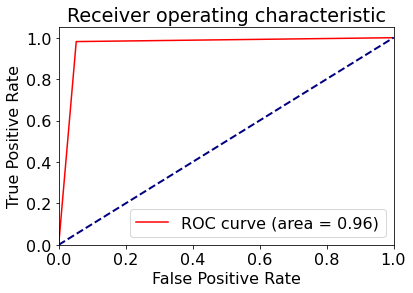

In [148]:
RF_predict_test_th_5 = RF_model_prob_pred_test_5[:,1] > RF_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [149]:
(1.0-RF_best_th_5)
rf_th_5 = round((1.0-RF_best_th_5),3)
rf_th_5

0.6374798412138521

0.637

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.98      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14807   818]
 [    7   368]]
Accuracy: 0.9484375
roc_auc_score: 0.9644906666666667
precision_score: 0.3102866779089376
recall_score: 0.9813333333333333
f1_score: 0.4714926329276105
CM: FP 818
CM: FN 7
APS Cost =  11680


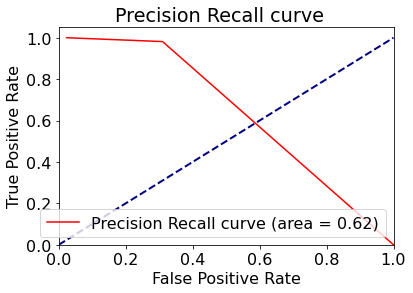

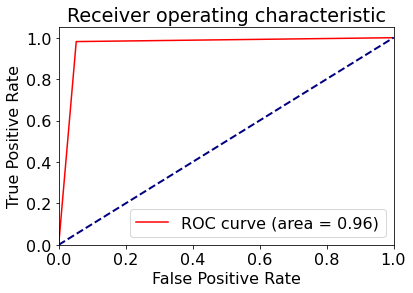

In [150]:
y_5 = RF_model_prob_pred_test_5[:,0] < rf_th_5
model_evaluaiton(y_test, y_5, "")

-----

### df_train_10 (i.e. IR = 0.6)

In [151]:
X_train_10, y_train_10 = get_train_data(df_train_10)
RF_best_model_10 = RF_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   45.6s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.7s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.96      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14972   653]
 [   14   361]]
Accuracy: 0.9583125
roc_auc_score: 0.9604373333333334
precision_score: 0.3560

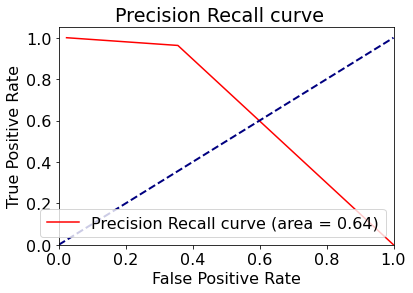

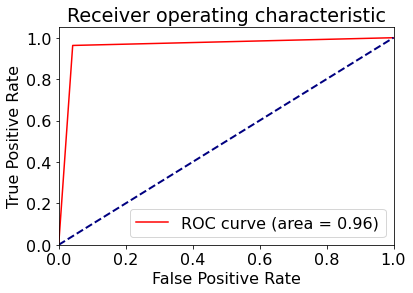

In [152]:
RF_model_pred_test_10, RF_model_prob_pred_test_10 = model_prediction(RF_best_model_10, X_test)
model_evaluaiton(y_test, RF_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59000
           1       0.79      0.98      0.87     10000

    accuracy                           0.96     69000
   macro avg       0.89      0.97      0.93     69000
weighted avg       0.97      0.96      0.96     69000

[[56437  2563]
 [  240  9760]]
Accuracy: 0.9593768115942028
roc_auc_score: 0.9662796610169492
precision_scor

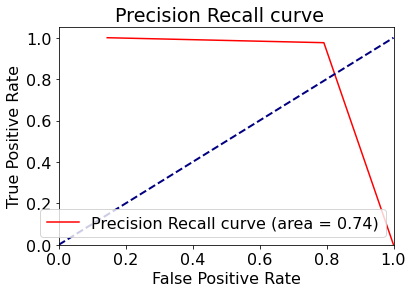

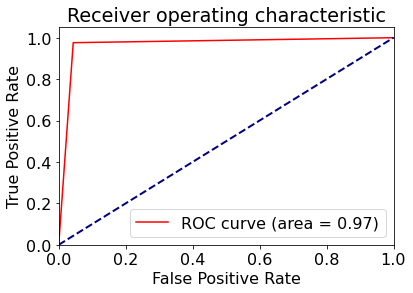

In [153]:
RF_model_pred_train_10, RF_model_prob_pred_train_10 = model_prediction(RF_best_model_10, X_train_10)
model_evaluaiton(y_train_10, RF_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [154]:
RF_best_th_10 = find_cut_off(y_test, RF_model_prob_pred_test_10[:,1])

100%|██████████| 2206/2206 [01:26<00:00, 25.48it/s]

Best threshold: 0.3846
Min cost: 11340.00


In [155]:
RF_best_th_10

0.3846324309640158

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.97      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14841   784]
 [    7   368]]
Accuracy: 0.9505625
roc_auc_score: 0.9655786666666666
precision_score: 0.3194444444444444
recall_score: 0.9813333333333333
f1_score: 0.4819908316961361
CM: FP 784
CM: FN 7
APS Cost =  11340


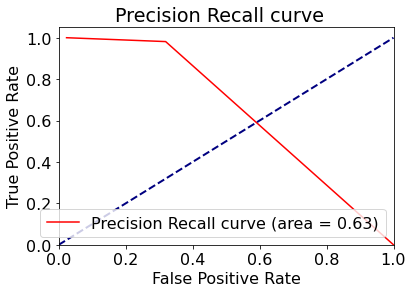

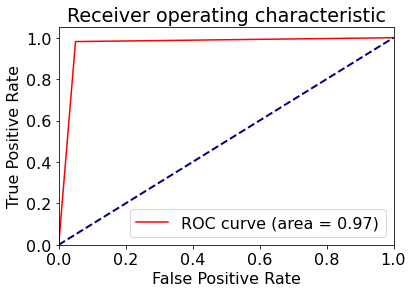

In [156]:
RF_predict_test_th_10 = RF_model_prob_pred_test_10[:,1] > RF_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [157]:
(1.0-RF_best_th_10)
rf_th_10 = round((1.0-RF_best_th_10),3)
rf_th_10

0.6153675690359842

0.615

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14841   784]
 [    8   367]]
Accuracy: 0.9505
roc_auc_score: 0.9642453333333334
precision_score: 0.3188531711555169
recall_score: 0.9786666666666667
f1_score: 0.4809960681520315
CM: FP 784
CM: FN 8
APS Cost =  11840


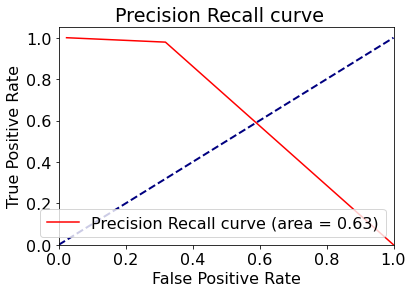

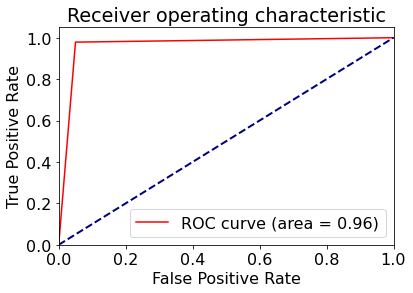

In [158]:
y_10 = RF_model_prob_pred_test_10[:,0] < rf_th_10
model_evaluaiton(y_test, y_10, "")

---

### df_train_18 (i.e. IR = 0.8)

In [159]:
X_train_18, y_train_18 = get_train_data(df_train_18)
RF_best_model_18 = RF_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.9s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.9s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.97      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14975   650]
 [   13   362]]
Accuracy: 0.9585625
roc_auc_score: 0.9618666666666668
precision_score: 0.3577

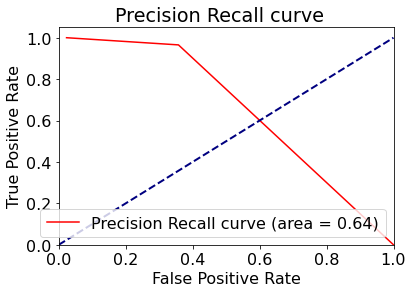

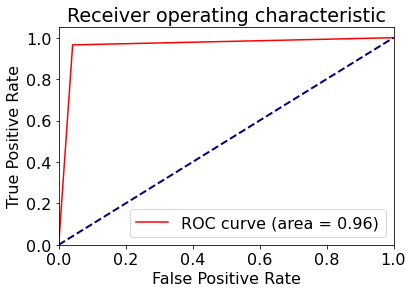

In [160]:
RF_model_pred_test_18, RF_model_prob_pred_test_18 = model_prediction(RF_best_model_18, X_test)
model_evaluaiton(y_test, RF_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     59000
           1       0.87      0.98      0.92     18000

    accuracy                           0.96     77000
   macro avg       0.93      0.97      0.95     77000
weighted avg       0.96      0.96      0.96     77000

[[56430  2570]
 [  417 17583]]
Accuracy: 0.9612077922077922
roc_auc_score: 0.9666370056497176
precision_scor

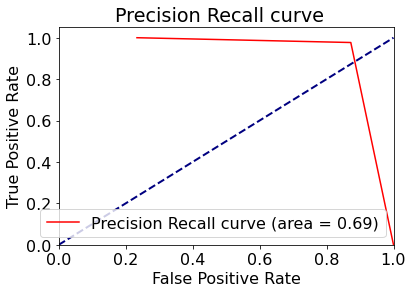

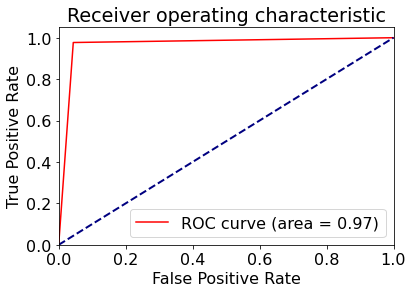

In [161]:
RF_model_pred_train_18, RF_model_prob_pred_train_18 = model_prediction(RF_best_model_18, X_train_18)
model_evaluaiton(y_train_18, RF_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [162]:
RF_best_th_18 = find_cut_off(y_test, RF_model_prob_pred_test_18[:,1])

100%|██████████| 2550/2550 [01:46<00:00, 23.97it/s]

Best threshold: 0.3783
Min cost: 11350.00


In [163]:
RF_best_th_18

0.37827466969277546

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.97      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14840   785]
 [    7   368]]
Accuracy: 0.9505
roc_auc_score: 0.9655466666666667
precision_score: 0.3191673894189072
recall_score: 0.9813333333333333
f1_score: 0.4816753926701571
CM: FP 785
CM: FN 7
APS Cost =  11350


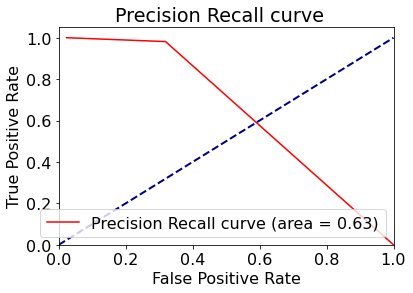

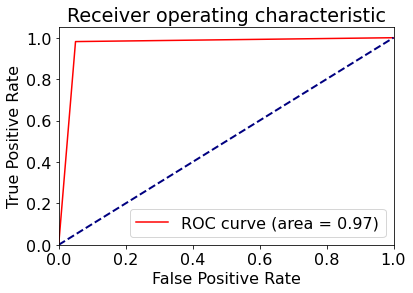

In [164]:
RF_predict_test_th_18 = RF_model_prob_pred_test_18[:,1] > RF_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [165]:
(1.0-RF_best_th_18)
rf_th_18 = round((1.0-RF_best_th_18),3)
rf_th_18

0.6217253303072245

0.622

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.97      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14838   787]
 [    7   368]]
Accuracy: 0.950375
roc_auc_score: 0.9654826666666666
precision_score: 0.31861471861471863
recall_score: 0.9813333333333333
f1_score: 0.48104575163398694
CM: FP 787
CM: FN 7
APS Cost =  11370


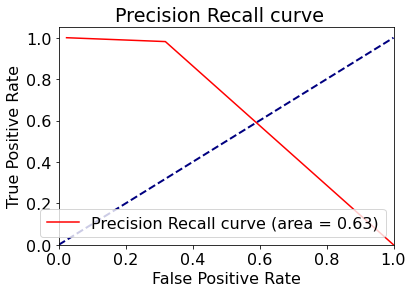

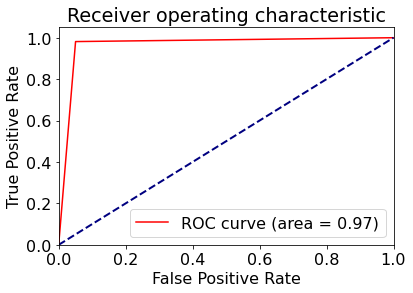

In [166]:
y_18 = RF_model_prob_pred_test_18[:,0] < rf_th_18
model_evaluaiton(y_test, y_18, "")

----

### df_train_59 (i.e. IR = 1.0)

In [167]:
X_train_59, y_train_59 = get_train_data(df_train_59)
RF_best_model_59 = RF_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.35      0.97      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14964   661]
 [   13   362]]
Accuracy: 0.957875
roc_auc_score: 0.9615146666666666
precision_score: 0.35386

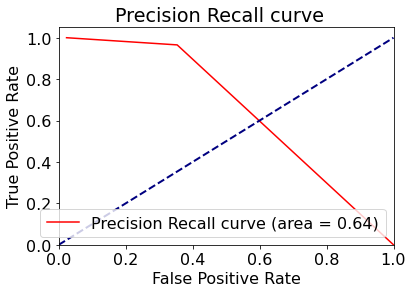

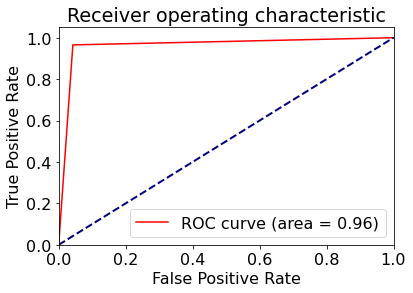

In [168]:
RF_model_pred_test_59, RF_model_prob_pred_test_59 = model_prediction(RF_best_model_59, X_test)
model_evaluaiton(y_test, RF_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     59000
           1       0.96      0.98      0.97     59000

    accuracy                           0.97    118000
   macro avg       0.97      0.97      0.97    118000
weighted avg       0.97      0.97      0.97    118000

[[56422  2578]
 [ 1395 57605]]
Accuracy: 0.9663305084745762
roc_auc_score: 0.9663305084745762
precision_scor

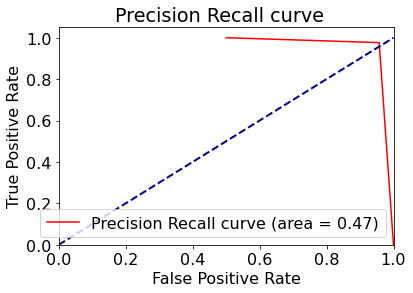

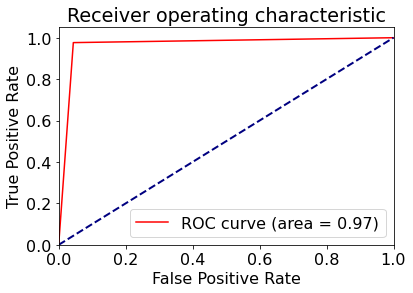

In [169]:
RF_model_pred_train_59, RF_model_prob_pred_train_59 = model_prediction(RF_best_model_59, X_train_59)
model_evaluaiton(y_train_59, RF_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [170]:
RF_best_th_59 = find_cut_off(y_test, RF_model_prob_pred_test_59[:,1])

100%|██████████| 2265/2265 [01:28<00:00, 25.47it/s]

Best threshold: 0.3807
Min cost: 11420.00


In [171]:
RF_best_th_59

0.3807136872143432

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.97      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14833   792]
 [    7   368]]
Accuracy: 0.9500625
roc_auc_score: 0.9653226666666667
precision_score: 0.31724137931034485
recall_score: 0.9813333333333333
f1_score: 0.4794788273615635
CM: FP 792
CM: FN 7
APS Cost =  11420


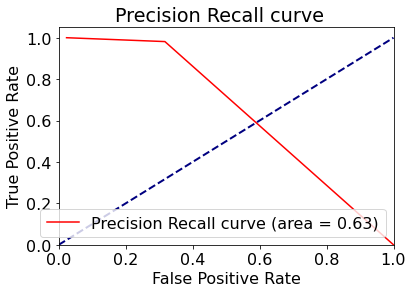

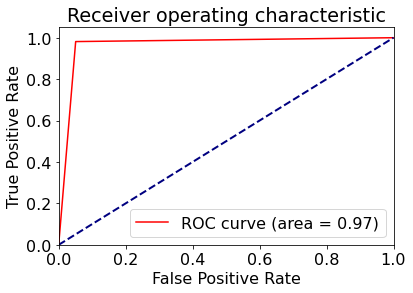

In [172]:
RF_predict_test_th_59 = RF_model_prob_pred_test_59[:,1] > RF_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [173]:
(1.0-RF_best_th_59)
rf_th_59 = round((1.0-RF_best_th_59),3)
rf_th_59

0.6192863127856568

0.619

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14833   792]
 [    8   367]]
Accuracy: 0.95
roc_auc_score: 0.9639893333333334
precision_score: 0.3166522864538395
recall_score: 0.9786666666666667
f1_score: 0.4784876140808344
CM: FP 792
CM: FN 8
APS Cost =  11920


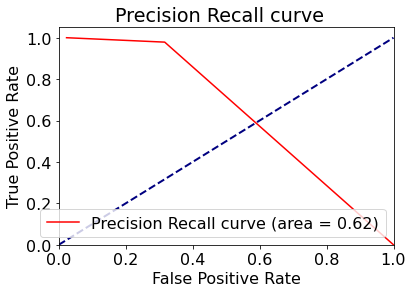

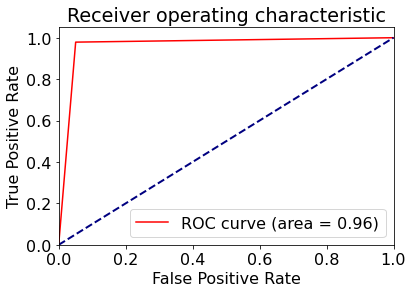

In [174]:
y_59 = RF_model_prob_pred_test_59[:,0] < rf_th_59
model_evaluaiton(y_test, y_59, "")

----

## XGBoost

In [175]:
def xgb_model(X_train, y_train):
    # xg_hyperparameters = {
    #                 'max_depth': [3, 4, 5],
    #                 'n_estimators': [50, 100],
    #                 'learning_rate': [0.1, 0.01, 0.05]
    #             }

    # best param when PCA is used
    xg_hyperparameters = {
                    'max_depth': [5],
                    'n_estimators': [100],
                    'learning_rate': [0.03]
                }
    xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)
    
    xgbb_best_model = xg_clf.fit(X_train, y_train)
    return xgbb_best_model

### df_train_2 (i.e. IR = 0.2)

In [176]:
X_train_2, y_train_2 = get_train_data(df_train_2)
xgb_best_model_2 = xgb_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.4min remaining:   56.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.86      0.77      0.81       375

    accuracy                           0.99     16000
   macro avg       0.93      0.88      0.90     16000
weighted avg       0.99      0.99      0.99     16000

[[15579    46]
 [   87   288]]
Accurac

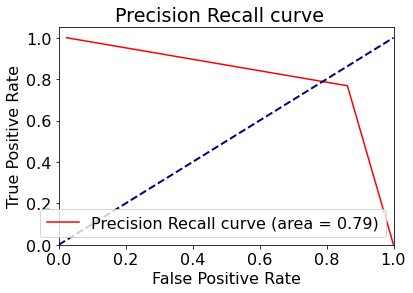

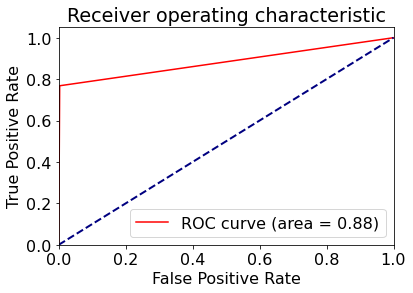

In [177]:
xgb_model_pred_test_2, xgb_model_prob_pred_test_2 = model_prediction(xgb_best_model_2, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.95      0.86      0.90      2000

    accuracy                           0.99     61000
   macro avg       0.97      0.93      0.95     61000
weighted avg       0.99      0.99      0.99     61000

[[58903    97]
 [  285  1715]]
Accurac

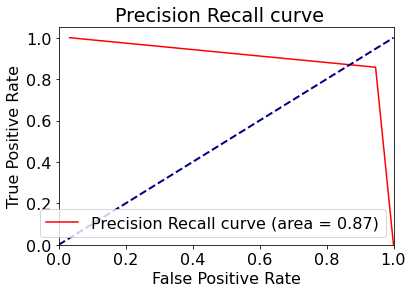

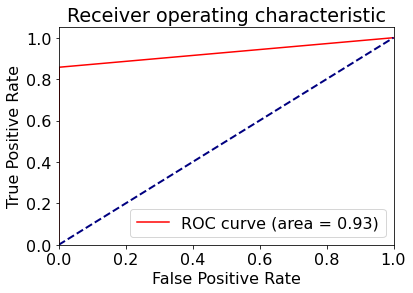

In [178]:
xgb_model_pred_train_2, xgb_model_prob_pred_train_2 = model_prediction(xgb_best_model_2, X_train_2)
model_evaluaiton(y_train_2, xgb_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [179]:
xgb_best_th_2 = find_cut_off(y_test, xgb_model_prob_pred_test_2[:,1])

100%|██████████| 1485/1485 [00:58<00:00, 25.31it/s]

Best threshold: 0.0652
Min cost: 8890.00


In [180]:
xgb_best_th_2

0.06524369

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.41      0.98      0.57       375

    accuracy                           0.97     16000
   macro avg       0.70      0.97      0.78     16000
weighted avg       0.99      0.97      0.97     16000

[[15086   539]
 [    7   368]]
Accuracy: 0.965875
roc_auc_score: 0.9734186666666665
precision_score: 0.40573318632855565
recall_score: 0.9813333333333333
f1_score: 0.5741029641185647
CM: FP 539
CM: FN 7
APS Cost =  8890


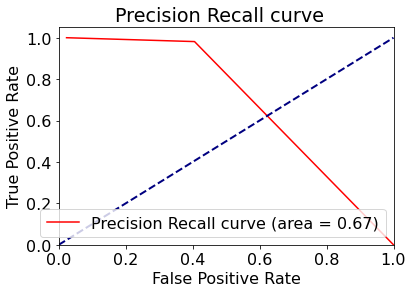

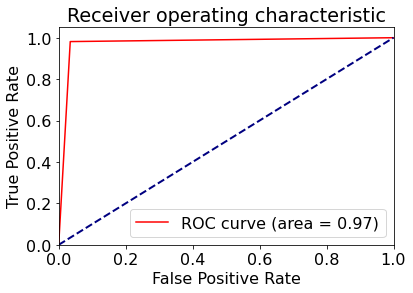

In [181]:
xgb_predict_test_th_2 = xgb_model_prob_pred_test_2[:,1] > xgb_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [182]:
(1.0-xgb_best_th_2)
xg_th_2 = round((1.0-xgb_best_th_2),3)
xg_th_2

0.9347563087940216

0.935

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.40      0.98      0.57       375

    accuracy                           0.97     16000
   macro avg       0.70      0.97      0.78     16000
weighted avg       0.99      0.97      0.97     16000

[[15080   545]
 [    7   368]]
Accuracy: 0.9655
roc_auc_score: 0.9732266666666665
precision_score: 0.40306681270536693
recall_score: 0.9813333333333333
f1_score: 0.5714285714285714
CM: FP 545
CM: FN 7
APS Cost =  8950


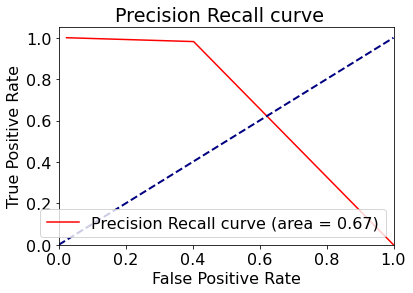

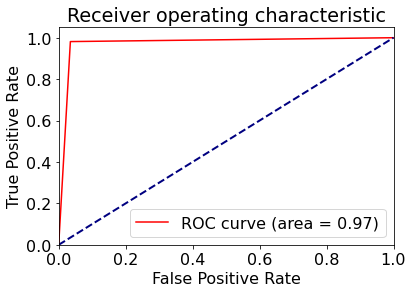

In [183]:
y_2 = xgb_model_prob_pred_test_2[:,0] < xg_th_2
model_evaluaiton(y_test, y_2, "")

-----

### df_train_5 (i.e. IR = 0.4)

In [184]:
X_train_5, y_train_5 = get_train_data(df_train_5)
xgb_best_model_5 = xgb_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.76      0.83      0.80       375

    accuracy                           0.99     16000
   macro avg       0.88      0.91      0.90     16000
weighted avg       0.99      0.99      0.99     16000

[[15529    96]
 [   64   311]]
Accurac

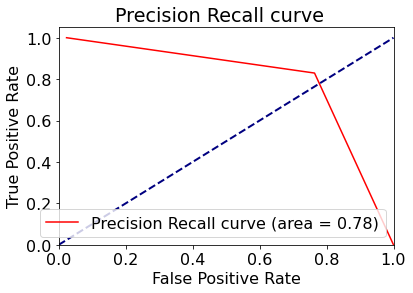

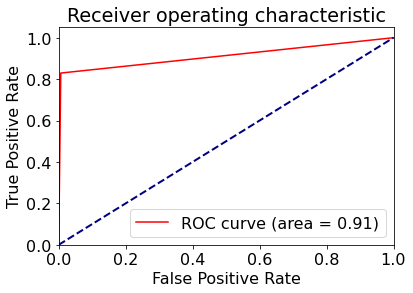

In [185]:
xgb_model_pred_test_5, xgb_model_prob_pred_test_5 = model_prediction(xgb_best_model_5, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59000
           1       0.94      0.93      0.93      5000

    accuracy                           0.99     64000
   macro avg       0.97      0.96      0.96     64000
weighted avg       0.99      0.99      0.99     64000

[[58694   306]
 [  368  4632]]
Accurac

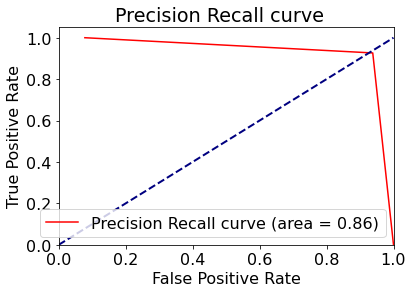

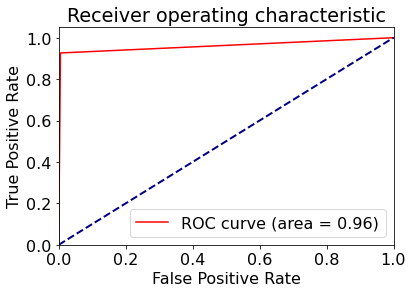

In [186]:
xgb_model_pred_train_5, xgb_model_prob_pred_train_5 = model_prediction(xgb_best_model_5, X_train_5)
model_evaluaiton(y_train_5, xgb_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [187]:
xgb_best_th_5 = find_cut_off(y_test, xgb_model_prob_pred_test_5[:,1])

100%|██████████| 2070/2070 [01:20<00:00, 25.57it/s]

Best threshold: 0.0887
Min cost: 9670.00


In [188]:
xgb_best_th_5

0.088679366

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.39      0.98      0.56       375

    accuracy                           0.96     16000
   macro avg       0.70      0.97      0.77     16000
weighted avg       0.99      0.96      0.97     16000

[[15058   567]
 [    8   367]]
Accuracy: 0.9640625
roc_auc_score: 0.9711893333333333
precision_score: 0.3929336188436831
recall_score: 0.9786666666666667
f1_score: 0.5607333842627961
CM: FP 567
CM: FN 8
APS Cost =  9670


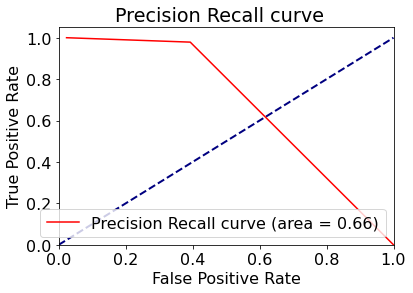

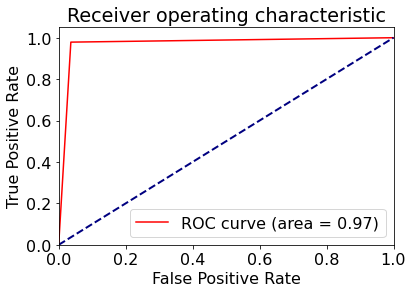

In [189]:
xgb_predict_test_th_5 = xgb_model_prob_pred_test_5[:,1] > xgb_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [190]:
(1.0-xgb_best_th_5)
xg_th_5 = round((1.0-xgb_best_th_5),3)
xg_th_5

0.9113206341862679

0.911

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.39      0.98      0.56       375

    accuracy                           0.96     16000
   macro avg       0.70      0.97      0.77     16000
weighted avg       0.99      0.96      0.97     16000

[[15058   567]
 [    9   366]]
Accuracy: 0.964
roc_auc_score: 0.9698559999999999
precision_score: 0.39228295819935693
recall_score: 0.976
f1_score: 0.5596330275229359
CM: FP 567
CM: FN 9
APS Cost =  10170


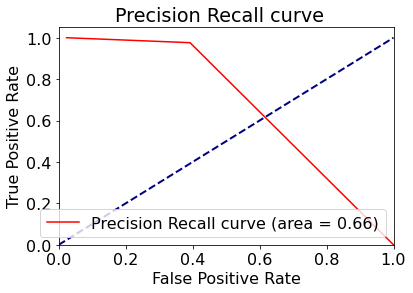

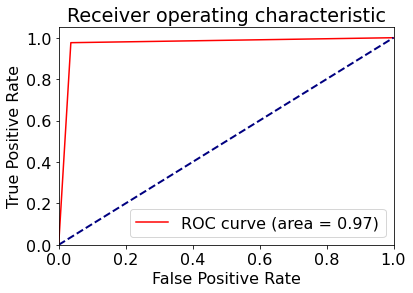

In [191]:
y_5 = xgb_model_prob_pred_test_5[:,0] < xg_th_5
model_evaluaiton(y_test, y_5, "")

----

### df_train_10 (i.e. IR = 0.6)

In [192]:
X_train_10, y_train_10 = get_train_data(df_train_10)
xgb_best_model_10 = xgb_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.66      0.86      0.74       375

    accuracy                           0.99     16000
   macro avg       0.83      0.92      0.87     16000
weighted avg       0.99      0.99      0.99     16000

[[15457   168]
 [   53   322]]
Accurac

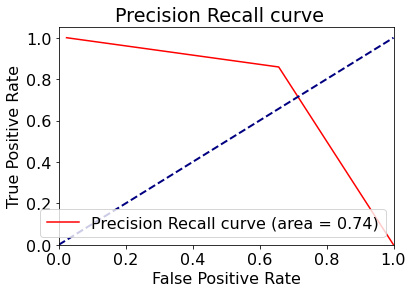

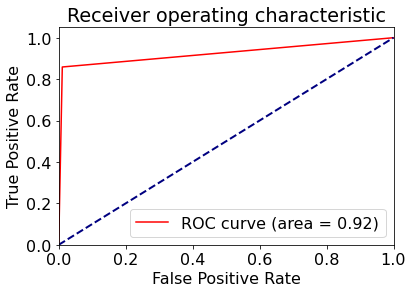

In [193]:
xgb_model_pred_test_10, xgb_model_prob_pred_test_10 = model_prediction(xgb_best_model_10, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59000
           1       0.95      0.95      0.95     10000

    accuracy                           0.99     69000
   macro avg       0.97      0.97      0.97     69000
weighted avg       0.99      0.99      0.99     69000

[[58454   546]
 [  478  9522]]
Accurac

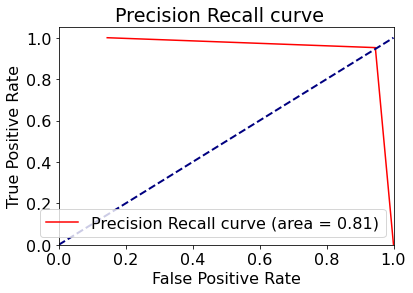

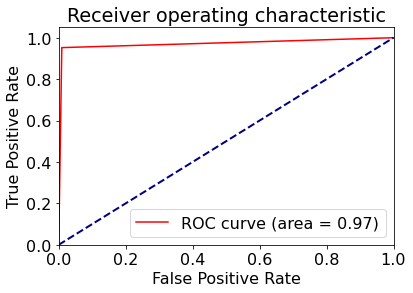

In [194]:
xgb_model_pred_train_10, xgb_model_prob_pred_train_10 = model_prediction(xgb_best_model_10, X_train_10)
model_evaluaiton(y_train_10, xgb_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [195]:
xgb_best_th_10 = find_cut_off(y_test, xgb_model_prob_pred_test_10[:,1])

100%|██████████| 2517/2517 [01:39<00:00, 25.36it/s]

Best threshold: 0.1068
Min cost: 9050.00


In [196]:
xgb_best_th_10

0.106781796

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.38      0.98      0.55       375

    accuracy                           0.96     16000
   macro avg       0.69      0.97      0.76     16000
weighted avg       0.99      0.96      0.97     16000

[[15020   605]
 [    6   369]]
Accuracy: 0.9618125
roc_auc_score: 0.9726400000000001
precision_score: 0.3788501026694045
recall_score: 0.984
f1_score: 0.5470719051148999
CM: FP 605
CM: FN 6
APS Cost =  9050


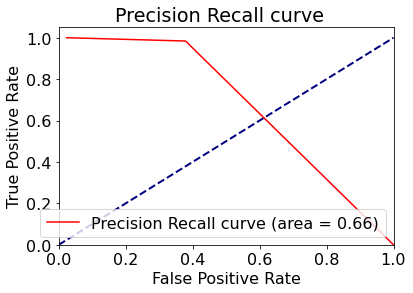

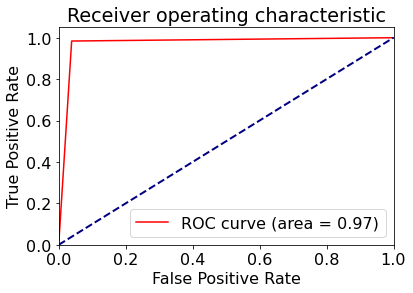

In [197]:
xgb_predict_test_th_10 = xgb_model_prob_pred_test_10[:,1] > xgb_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [198]:
(1.0-xgb_best_th_10)
xg_th_10 = round((1.0-xgb_best_th_10),3)
xg_th_10

0.8932182043790817

0.893

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.38      0.98      0.55       375

    accuracy                           0.96     16000
   macro avg       0.69      0.97      0.76     16000
weighted avg       0.99      0.96      0.97     16000

[[15020   605]
 [    6   369]]
Accuracy: 0.9618125
roc_auc_score: 0.9726400000000001
precision_score: 0.3788501026694045
recall_score: 0.984
f1_score: 0.5470719051148999
CM: FP 605
CM: FN 6
APS Cost =  9050


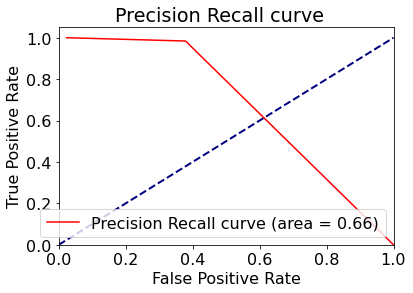

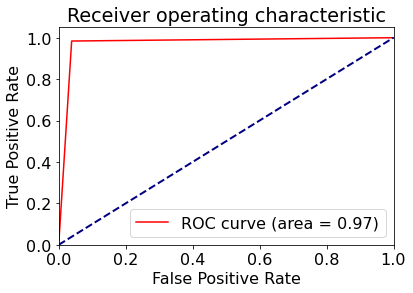

In [199]:
y_10 = xgb_model_prob_pred_test_10[:,0] < xg_th_10
model_evaluaiton(y_test, y_10, "")

-----

### df_train_18 (i.e. IR = 0.8)

In [200]:
X_train_18, y_train_18 = get_train_data(df_train_18)
xgb_best_model_18 = xgb_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.62      0.88      0.73       375

    accuracy                           0.98     16000
   macro avg       0.81      0.93      0.86     16000
weighted avg       0.99      0.98      0.99     16000

[[15421   204]
 [   44   331]]
Accurac

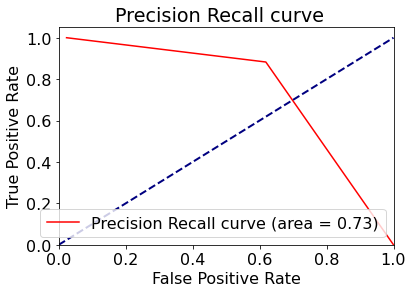

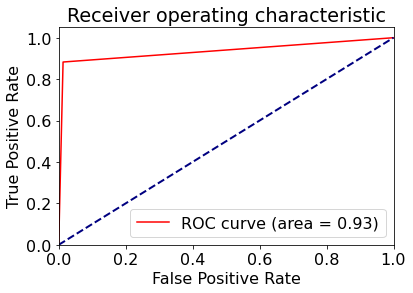

In [201]:
xgb_model_pred_test_18, xgb_model_prob_pred_test_18 = model_prediction(xgb_best_model_18, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59000
           1       0.96      0.97      0.96     18000

    accuracy                           0.98     77000
   macro avg       0.97      0.98      0.98     77000
weighted avg       0.98      0.98      0.98     77000

[[58253   747]
 [  581 17419]]
Accurac

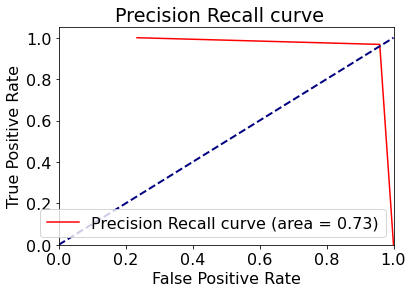

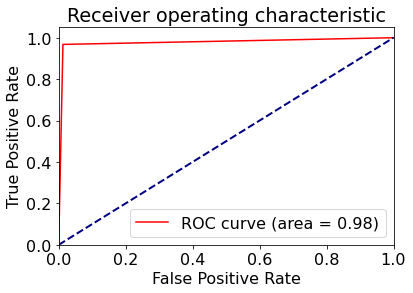

In [202]:
xgb_model_pred_train_18, xgb_model_prob_pred_train_18 = model_prediction(xgb_best_model_18, X_train_18)
model_evaluaiton(y_train_18, xgb_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [203]:
xgb_best_th_18 = find_cut_off(y_test, xgb_model_prob_pred_test_18[:,1])

100%|██████████| 3103/3103 [02:03<00:00, 25.16it/s]

Best threshold: 0.1240
Min cost: 8690.00


In [204]:
xgb_best_th_18

0.123975575

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.99      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14956   669]
 [    4   371]]
Accuracy: 0.9579375
roc_auc_score: 0.9732586666666667
precision_score: 0.35673076923076924
recall_score: 0.9893333333333333
f1_score: 0.5243816254416961
CM: FP 669
CM: FN 4
APS Cost =  8690


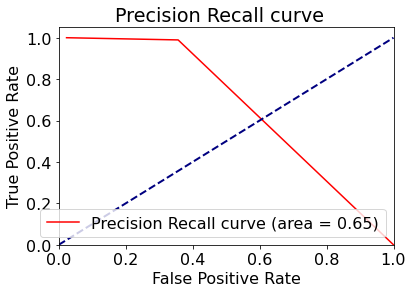

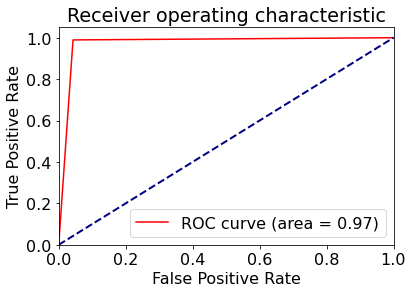

In [205]:
xgb_predict_test_th_18 = xgb_model_prob_pred_test_18[:,1] > xgb_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [206]:
(1.0-xgb_best_th_18)
xg_th_18 = round((1.0-xgb_best_th_18),3)
xg_th_18

0.8760244250297546

0.876

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.99      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14956   669]
 [    4   371]]
Accuracy: 0.9579375
roc_auc_score: 0.9732586666666667
precision_score: 0.35673076923076924
recall_score: 0.9893333333333333
f1_score: 0.5243816254416961
CM: FP 669
CM: FN 4
APS Cost =  8690


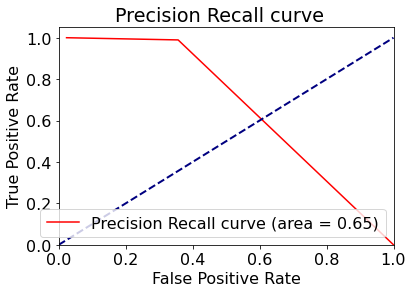

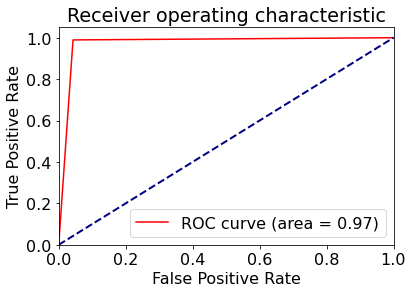

In [207]:
y_18 = xgb_model_prob_pred_test_18[:,0] < xg_th_18
model_evaluaiton(y_test, y_18, "")

-----

### df_train_59 (i.e. IR = 1.0)

In [208]:
X_train_59, y_train_59 = get_train_data(df_train_59)
xgb_best_model_59 = xgb_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.52      0.91      0.66       375

    accuracy                           0.98     16000
   macro avg       0.76      0.95      0.83     16000
weighted avg       0.99      0.98      0.98     16000

[[15306   319]
 [   32   343]]
Accurac

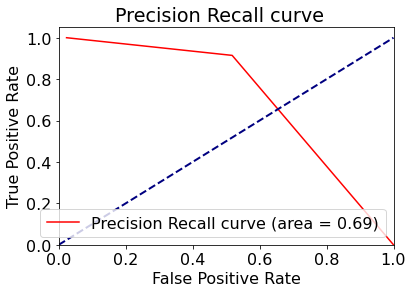

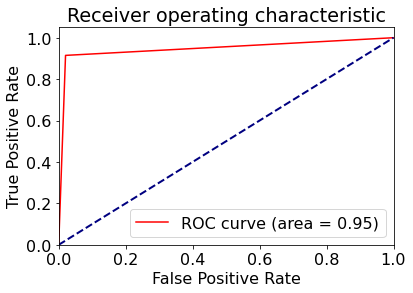

In [209]:
xgb_model_pred_test_59, xgb_model_prob_pred_test_59 = model_prediction(xgb_best_model_59, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     59000
           1       0.98      0.99      0.98     59000

    accuracy                           0.98    118000
   macro avg       0.98      0.98      0.98    118000
weighted avg       0.98      0.98      0.98    118000

[[57763  1237]
 [  553 58447]]
Accurac

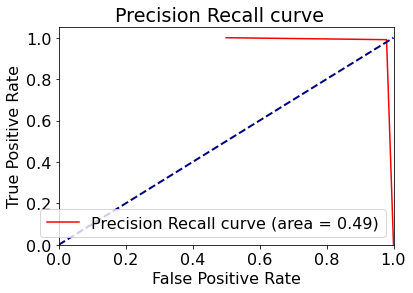

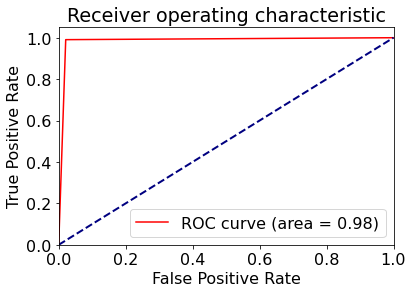

In [210]:
xgb_model_pred_train_59, xgb_model_prob_pred_train_59 = model_prediction(xgb_best_model_59, X_train_59)
model_evaluaiton(y_train_59, xgb_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [211]:
xgb_best_th_59 = find_cut_off(y_test, xgb_model_prob_pred_test_59[:,1])

100%|██████████| 4889/4889 [03:47<00:00, 21.44it/s]

Best threshold: 0.1729
Min cost: 10300.00


In [212]:
xgb_best_th_59

0.17293924

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15625
           1       0.34      0.98      0.50       375

    accuracy                           0.95     16000
   macro avg       0.67      0.97      0.74     16000
weighted avg       0.98      0.95      0.96     16000

[[14895   730]
 [    6   369]]
Accuracy: 0.954
roc_auc_score: 0.9686400000000001
precision_score: 0.33575978161965425
recall_score: 0.984
f1_score: 0.5006784260515603
CM: FP 730
CM: FN 6
APS Cost =  10300


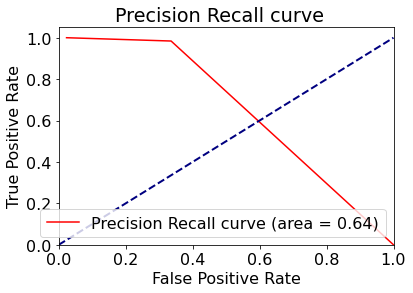

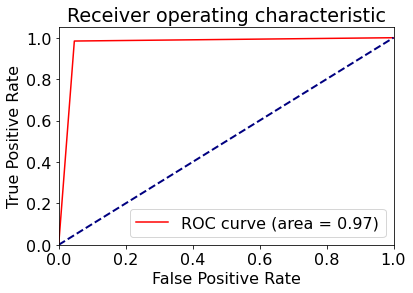

In [213]:
xgb_predict_test_th_59 = xgb_model_prob_pred_test_59[:,1] > xgb_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [214]:
(1.0-xgb_best_th_59)
xg_th_59 = round((1.0-xgb_best_th_59),3)
xg_th_59

0.8270607590675354

0.827

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15625
           1       0.34      0.98      0.50       375

    accuracy                           0.95     16000
   macro avg       0.67      0.97      0.74     16000
weighted avg       0.98      0.95      0.96     16000

[[14895   730]
 [    6   369]]
Accuracy: 0.954
roc_auc_score: 0.9686400000000001
precision_score: 0.33575978161965425
recall_score: 0.984
f1_score: 0.5006784260515603
CM: FP 730
CM: FN 6
APS Cost =  10300


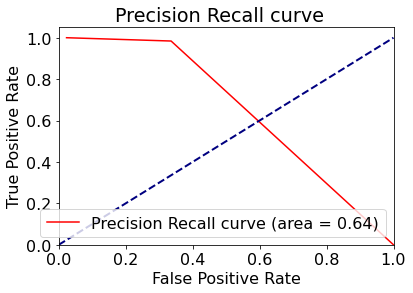

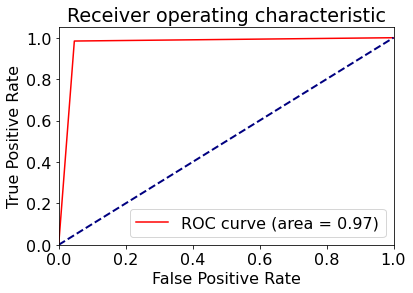

In [215]:
y_59 = xgb_model_prob_pred_test_59[:,0] < xg_th_59
model_evaluaiton(y_test, y_59, "")

-----